In [19]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 修改中文字體
plt.rcParams['axes.unicode_minus'] = False # 顯示負號

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("news_raw.csv", encoding="utf-8")
titles = df["title"].values
titles =titles.tolist()


In [20]:
import pandas as pd
import jieba
import re

# 載入資料
df = pd.read_csv("news_raw.csv", encoding="utf-8")
titles = df["title"].fillna("").tolist()

# 前處理函數：清洗 + 斷詞
def preprocess(text):
    text = re.sub(r"[^\u4e00-\u9fa5a-zA-Z0-9]", "", text)  # 去除非中英文與數字
    tokens = list(jieba.cut(text))
    return " ".join(tokens)  # sklearn 要的是字串，詞用空格分隔

# 進行斷詞並建立新欄位
df["title_cut"] = df["title"].map(preprocess)

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

# 建立向量化工具
vectorizer = CountVectorizer(max_df=0.9, min_df=2)  # 可根據需要微調 min/max df
X = vectorizer.fit_transform(df["title_cut"])

In [22]:
from sklearn.decomposition import LatentDirichletAllocation

# 設定主題數量
n_topics = 3

# 建立並訓練模型
lda_model = LatentDirichletAllocation(n_components=n_topics,
                                      random_state=42,
                                      learning_method='batch')
lda_model.fit(X)

LatentDirichletAllocation(n_components=3, random_state=42)

In [23]:
# 取得所有關鍵詞對應的 index -> 詞
terms = vectorizer.get_feature_names_out()

def print_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        print(f"主題 {idx + 1}: {' | '.join(top_words)}")

print_topics(lda_model, terms)

主題 1: 利率 | 新高 | 如何 | 10 | 降息 | 聯準 | 影響 | 避險 | 美債 | fed
主題 2: 比特 | 降息 | 策略 | etf | 美國 | 美股 | 經濟 | btc | 貨幣 | 推出
主題 3: 美元 | 川普 | 關稅 | 比特 | 美股 | 聯準 | 警告 | 預期 | 華爾街 | 12


In [24]:
# 推論主題機率
topic_distributions = lda_model.transform(X)  # 每篇文章的主題機率分佈

# 取最大機率所對應的主題
dominant_topic = topic_distributions.argmax(axis=1)
df["lda_topic"] = dominant_topic  # 將主題加入原始 dataframe

In [25]:
with open("news_raw.csv", "w", encoding="utf-8") as f:
    df.to_csv(f, index=False)  # 儲存結果到原始檔案

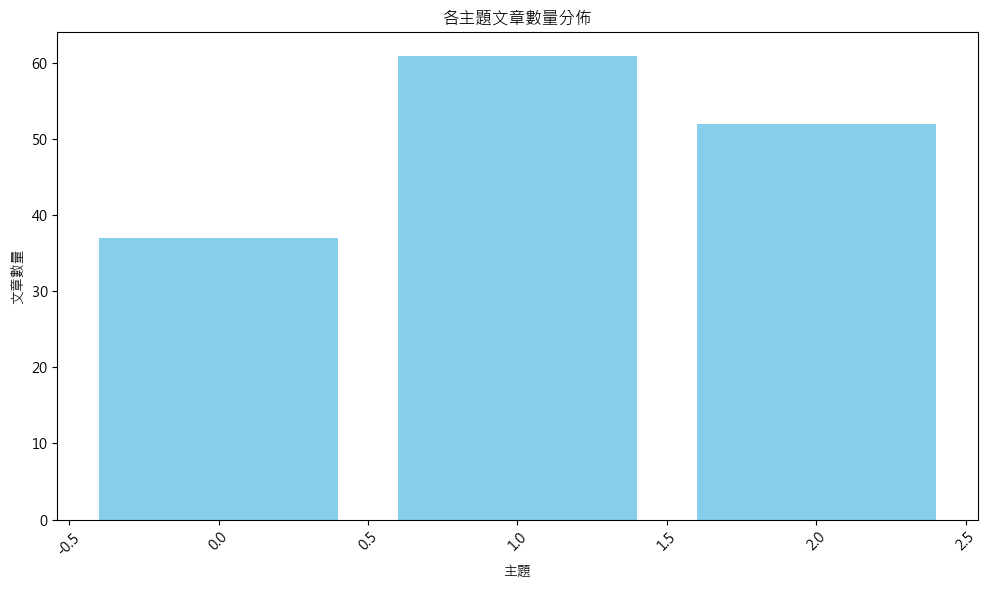

In [26]:
plt.figure(figsize=(10, 6))
plt.bar(df["lda_topic"].value_counts().index, df["lda_topic"].value_counts().values, color='skyblue')
plt.title("各主題文章數量分佈")
plt.xlabel("主題")
plt.ylabel("文章數量")
plt.xticks(rotation=45)
plt.tight_layout()